示例为利用pytorch中的CNN进行MNIST字体识别

In [1]:
import os
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [92]:
# torch.manual_seed(1)

# 超参数
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001   # 学习率
DOWNLOAD_MNIST = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # 选择CPU或GPU

In [7]:
# 下载训练数据
import torchvision
if not os.path.exists("./mnist/") or not os.listdir('./mnist/'):
    DOWNLOAD_MNIST = True
    
train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, 
                                       transform=torchvision.transforms.ToTensor(), download=DOWNLOAD_MNIST)

0it [00:00, ?it/s]

100%|█████████▉| 9863168/9912422 [02:03<00:01, 25314.80it/s] 

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]

9920512it [02:20, 25314.80it/s]                             
 57%|█████▋    | 16384/28881 [00:49<00:00, 32189.45it/s]

0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz




  0%|          | 0/1648877 [00:04<?, ?it/s]

  1%|          | 16384/1648877 [00:05<00:50, 32404.10it/s]

  2%|▏         | 40960/1648877 [00:05<00:42, 37608.63it/s]

  6%|▌         | 98304/1648877 [00:06<00:33, 46967.19it/s]

 10%|▉         | 163840/1648877 [00:06<00:25, 57989.73it/s]

 13%|█▎        | 212992/1648877 [00:07<00:21, 65760.12it/s]

 15%|█▍        | 245760/1648877 [00:07<00:19, 70692.82it/s]
32768it [01:06, 32189.45it/s]                           

 18%|█▊        | 303104/1648877 [00:26<00:19, 70692.82it/s]

 19%|█▉        | 311296/1648877 [02:40<15:46, 1413.39it/s] 

 24%|██▍       | 401408/1648877 [02:40<10:19, 2012.18it/s]

 27%|██▋       | 450560/1648877 [02:41<07:00, 2851.69it/s]

 30%|██▉       | 491520/1648877 [02:41<04:48, 4018.15it/s]

 30%|███       | 499712/1648877 [02:41<03:37, 5280.07it/s]

 33%|███▎      | 548864/1648877 [02:42<02:29, 7370.94it/s]

 35%|███▌      | 581632/1648877 [02:42<01:45, 10124.92it/s]

 38%|███▊      | 622592/1648877 [02:43<01:14, 1384

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz





  0%|          | 0/4542 [00:02<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!




1654784it [03:16, 11393.27it/s]                             

torch.Size([60000, 28, 28])
torch.Size([60000])


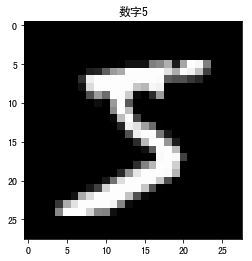

In [82]:
# plot
print(train_data.data.size())
print(train_data.targets.size())
plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title("数字{}".format(train_data.targets[0].numpy()))
plt.show()

In [93]:
# dataloader
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
train_x_batch, train_y_batch=next(iter(train_loader))
print(train_x_batch.shape)
print(train_y_batch.shape)

torch.Size([50, 1, 28, 28])
torch.Size([50])


In [84]:
train_y_batch

tensor([3, 6, 5, 7, 2, 2, 1, 1, 2, 5, 3, 3, 6, 8, 2, 2, 8, 1, 8, 6, 8, 3, 1, 3,
        3, 1, 1, 5, 0, 2, 4, 1, 7, 0, 2, 6, 4, 7, 9, 9, 8, 7, 1, 7, 2, 0, 1, 2,
        7, 3])

In [94]:
# 选取测试数据
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_data_n = torch.unsqueeze(test_data.data.float(), dim=1)
test_label_n = test_data.targets
test_n = Data.TensorDataset(test_data_n, test_label_n)
test_loader = Data.DataLoader(dataset=test_n, batch_size=BATCH_SIZE, shuffle=True)
test_x_batch, test_y_batch=next(iter(test_loader))
print(test_x_batch.shape)
print(test_y_batch.shape)

torch.Size([50, 1, 28, 28])
torch.Size([50])


In [95]:
# 构建CNN网络
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1,28*28
        self.conv1=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5, padding=2),   # 1,28*28 ——> 16,28*28
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)     # 16,28*28 ——> 16, 14*14
        )
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5, padding=2),   # 16,14*14 ——> 32,14*14
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)     # 32,14*14 ——> 32,7*7
        )
        self.fc1 = torch.nn.Linear(32*7*7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # forward传递的tensor相较于module中还包括了batch，即dim=0
        x = x.view(x.size()[0], -1)   # 全连接层
        output = self.fc1(x)
        return output

net = Net().to(DEVICE)     # 移动到CPU或GPU
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)


In [96]:
# 定义优化器和损失函数
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [97]:
# 将训练的函数封装起来
def train(model, device, train_loader, optimizer, epoch):
    model.train()    # 训练模式
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criteria(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [98]:
# 将测试的函数封装起来
def test(model, device, test_loader):
    model.eval()     # 测试模式
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criteria(output, target)
            pred = torch.max(output, dim=1)[1]
            correct += torch.sum((pred==target))
    correct = int(correct.numpy())
    avg_loss = test_loss/len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [99]:
for epoch in range(1, EPOCH + 1):
    train(net, DEVICE, train_loader, optimizer, epoch)
    test(net, DEVICE, train_loader)

Train Epoch: 1 [1450/60000 (2%)]	Loss: 1.069325
Train Epoch: 1 [2950/60000 (5%)]	Loss: 0.469298
Train Epoch: 1 [4450/60000 (7%)]	Loss: 0.214996
Train Epoch: 1 [5950/60000 (10%)]	Loss: 0.519801
Train Epoch: 1 [7450/60000 (12%)]	Loss: 0.296257
Train Epoch: 1 [8950/60000 (15%)]	Loss: 0.273913
Train Epoch: 1 [10450/60000 (17%)]	Loss: 0.172666
Train Epoch: 1 [11950/60000 (20%)]	Loss: 0.295695
Train Epoch: 1 [13450/60000 (22%)]	Loss: 0.096153
Train Epoch: 1 [14950/60000 (25%)]	Loss: 0.093241
Train Epoch: 1 [16450/60000 (27%)]	Loss: 0.138215
Train Epoch: 1 [17950/60000 (30%)]	Loss: 0.106266
Train Epoch: 1 [19450/60000 (32%)]	Loss: 0.167032
Train Epoch: 1 [20950/60000 (35%)]	Loss: 0.198597
Train Epoch: 1 [22450/60000 (37%)]	Loss: 0.027744
Train Epoch: 1 [23950/60000 (40%)]	Loss: 0.051853
Train Epoch: 1 [25450/60000 (42%)]	Loss: 0.111037
Train Epoch: 1 [26950/60000 (45%)]	Loss: 0.228409
Train Epoch: 1 [28450/60000 (47%)]	Loss: 0.089811
Train Epoch: 1 [29950/60000 (50%)]	Loss: 0.076359
Train Epo